In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score

In [70]:
#loading the datasets
df= pd.read_csv("./app_usage_data.csv")

In [71]:
print(df.head())


                    App       Date      Time Duration
0   Screen off (locked)  5/17/2019  18:25:07  0:00:02
1  Screen on (unlocked)  5/17/2019  18:25:10  0:00:01
2   Screen off (locked)  5/17/2019  18:25:10  0:03:19
3  Screen on (unlocked)  5/17/2019  18:28:29  0:00:01
4              Settings  5/17/2019  18:28:30  0:00:03


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79339 entries, 0 to 79338
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   App       79339 non-null  object
 1   Date      79339 non-null  object
 2   Time      79339 non-null  object
 3   Duration  79339 non-null  object
dtypes: object(4)
memory usage: 2.4+ MB


In [73]:
df.describe()

,App,Date,Time,Duration
count,79339,79339,79339,79339
unique,151,168,44413,2405
top,Screen on (locked),8/22/2019,6:45:02,0:00:01
freq,16029,888,20,12982


In [74]:
df.isnull().sum()

App         0
Date        0
Time        0
Duration    0
dtype: int64

# FEATURE ENGINEERING

In [75]:
df['DateTime']= pd.to_datetime(df['Date'] +" " +df['Time'],format='%m/%d/%Y %H:%M:%S')
df['Date']= pd.to_datetime(df['Date'],format='%m/%d/%Y')

In [76]:
df.head()

,App,Date,Time,Duration,DateTime
0,Screen off (locked),2019-05-17,18:25:07,0:00:02,2019-05-17 18:25:07
1,Screen on (unlocked),2019-05-17,18:25:10,0:00:01,2019-05-17 18:25:10
2,Screen off (locked),2019-05-17,18:25:10,0:03:19,2019-05-17 18:25:10
3,Screen on (unlocked),2019-05-17,18:28:29,0:00:01,2019-05-17 18:28:29
4,Settings,2019-05-17,18:28:30,0:00:03,2019-05-17 18:28:30


In [77]:
df=df.sort_values(['DateTime'])

In [78]:
df

,App,Date,Time,Duration,DateTime
0,Screen off (locked),2019-05-17,18:25:07,0:00:02,2019-05-17 18:25:07
1,Screen on (unlocked),2019-05-17,18:25:10,0:00:01,2019-05-17 18:25:10
2,Screen off (locked),2019-05-17,18:25:10,0:03:19,2019-05-17 18:25:10
3,Screen on (unlocked),2019-05-17,18:28:29,0:00:01,2019-05-17 18:28:29
4,Settings,2019-05-17,18:28:30,0:00:03,2019-05-17 18:28:30
...,...,...,...,...,...
79334,Screen on (unlocked),2019-10-31,23:52:56,0:00:00,2019-10-31 23:52:56
79335,Screen on (locked),2019-10-31,23:52:56,0:00:00,2019-10-31 23:52:56
79336,Clock,2019-10-31,23:52:59,0:00:13,2019-10-31 23:52:59
79337,Clock,2019-10-31,23:53:15,0:00:06,2019-10-31 23:53:15


In [79]:
#find the number of days data was given
df['DateTime'].max() - df['DateTime'].min()

Timedelta('167 days 05:28:16')

In [80]:
redundant_activities=['Screen on (unlocked)','Screen off (locked)','Screen on (locked)', 'Screen off','Permission controller','System UI','Package installer',
'Device shutdown','Call Management']
df=df[~df['App'].isin(redundant_activities)]

In [81]:
df["App"].unique()

array(['Settings', 'MTP application', 'Contacts', 'Service mode',
       'HwModuleTest', 'Phone', 'SIM card manager', 'Camera', 'Messages',
       'WhatsApp', 'Storage booster', 'Galaxy Store', 'Instagram',
       'Google Play Store', 'Samsung Experience Service', 'Samsung Cloud',
       'App Usage', 'Gallery', 'YouTube', 'Google', 'Goodreads', 'Gmail',
       'Chrome', 'Call of Duty', 'My Galaxy', 'Galaxy Themes',
       'Samsung Keyboard', 'Hotstar', 'Zedge Ringtones & Wallpapers',
       'Media Storage', 'Finder', 'Medium', 'Evernote', 'Opera Mini',
       'Weather', 'Clock', 'IndPay', 'Amazon Kindle', 'Amazon Shopping',
       'Files', 'Samsung Music', 'Device boot', 'Mi Fit', 'Game Booster',
       'Video Player', 'My Files', 'Samsung Internet', 'Wallpapers',
       'Photo Editor', 'Google Pay', 'Galaxy Diagnostics', 'Camera Test',
       'Mobile networks', 'Google Play services', 'Software update',
       'Device maintenance', 'My Airtel', 'Airtel', 'Uber Eats', 'Swiggy',
       

In [82]:
df['Duration']

4        0:00:03
8        0:00:03
15       0:00:00
17       0:00:02
20       0:00:04
          ...   
79330    0:03:29
79331    0:00:47
79332    0:04:18
79336    0:00:13
79337    0:00:06
Name: Duration, Length: 29463, dtype: object

In [83]:
def calculate_seconds(x):
    temp=x.split(":")
    return int(temp[0]) * 3600 + int(temp[1])*60 + int(temp[2])
    
df['TotalSeconds']=df['Duration'].apply(lambda x:calculate_seconds(x))

/var/folders/g2/p0403xtd17b0vzxbl6vt43800000gn/T/ipykernel_39647/2509202740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalSeconds']=df['Duration'].apply(lambda x:calculate_seconds(x))


In [84]:
df.head()

,App,Date,Time,Duration,DateTime,TotalSeconds
4,Settings,2019-05-17,18:28:30,0:00:03,2019-05-17 18:28:30,3
8,Settings,2019-05-17,18:30:17,0:00:03,2019-05-17 18:30:17,3
15,MTP application,2019-05-17,18:30:24,0:00:00,2019-05-17 18:30:24,0
17,MTP application,2019-05-17,18:30:28,0:00:02,2019-05-17 18:30:28,2
20,Contacts,2019-05-17,18:42:24,0:00:04,2019-05-17 18:42:24,4


In [85]:
top_20_used_apps=df.groupby("App").sum().sort_values(['TotalSeconds'],ascending=False)[:20].reset_index()

In [86]:
top_20_used_apps

,App,TotalSeconds
0,Instagram,1030845
1,WhatsApp,460123
2,Phone,348651
3,YouTube,283133
4,Call of Duty,252630
5,Opera Mini,152205
6,Amazon Kindle,89942
7,Chrome,76634
8,MX Player,57245
9,Hotstar,48908


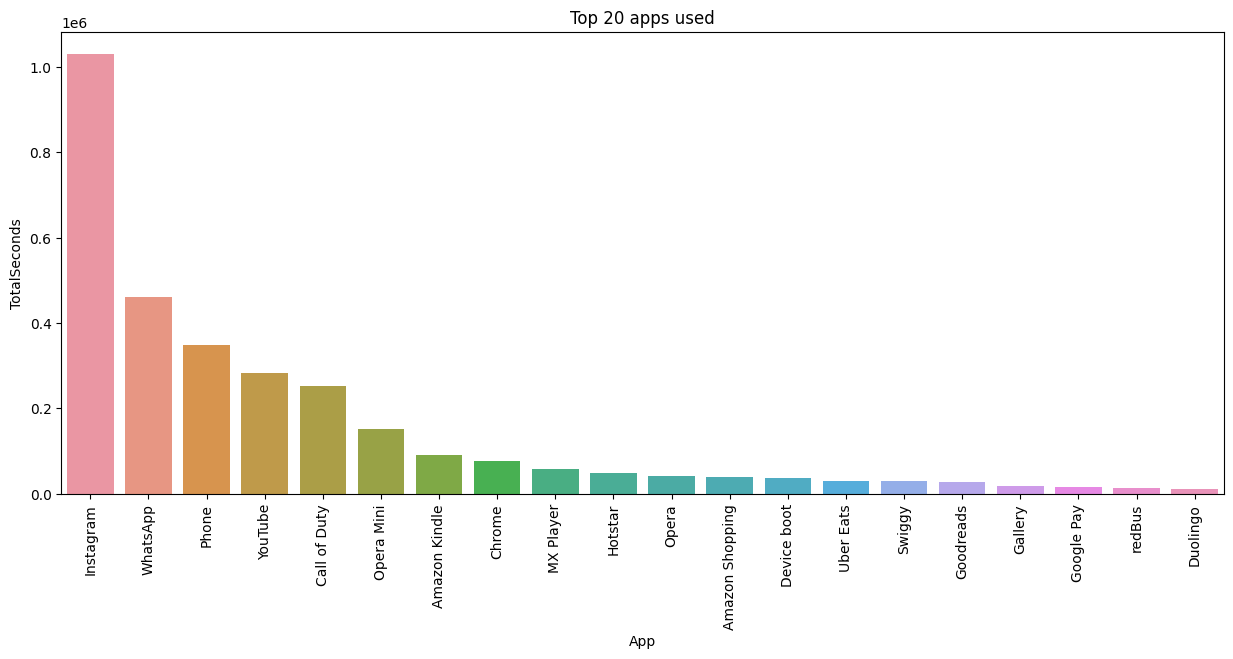

In [87]:
plt.figure(figsize=(15,6))
sns.barplot(x='App',y='TotalSeconds',data=top_20_used_apps)
plt.title('Top 20 apps used')
plt.xticks(rotation=90)
plt.show()

In [88]:
df=df.groupby(['Date','App']).sum().reset_index()
df['TotalMinutes'] = df['TotalSeconds'] // 60

In [89]:
df.head()

,Date,App,TotalSeconds,TotalMinutes
0,2019-05-17,App Usage,13,0
1,2019-05-17,Call of Duty,444,7
2,2019-05-17,Camera,53,0
3,2019-05-17,Chrome,39,0
4,2019-05-17,Contacts,24,0


In [90]:
def generateFeatures(df):
    features = ['day','dayofweek','month','quarter','year','dayofyear','weekofyear']
    for col in features:
        df[col] = getattr(df['Date'].dt,col) * 1

In [91]:
generateFeatures(df)

/var/folders/g2/p0403xtd17b0vzxbl6vt43800000gn/T/ipykernel_39647/660557356.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[col] = getattr(df['Date'].dt,col) * 1


In [92]:
df.head(5)

,Date,App,TotalSeconds,TotalMinutes,day,dayofweek,month,quarter,year,dayofyear,weekofyear
0,2019-05-17,App Usage,13,0,17,4,5,2,2019,137,20
1,2019-05-17,Call of Duty,444,7,17,4,5,2,2019,137,20
2,2019-05-17,Camera,53,0,17,4,5,2,2019,137,20
3,2019-05-17,Chrome,39,0,17,4,5,2,2019,137,20
4,2019-05-17,Contacts,24,0,17,4,5,2,2019,137,20


# EXPLORATORY DATA ANALYSIS

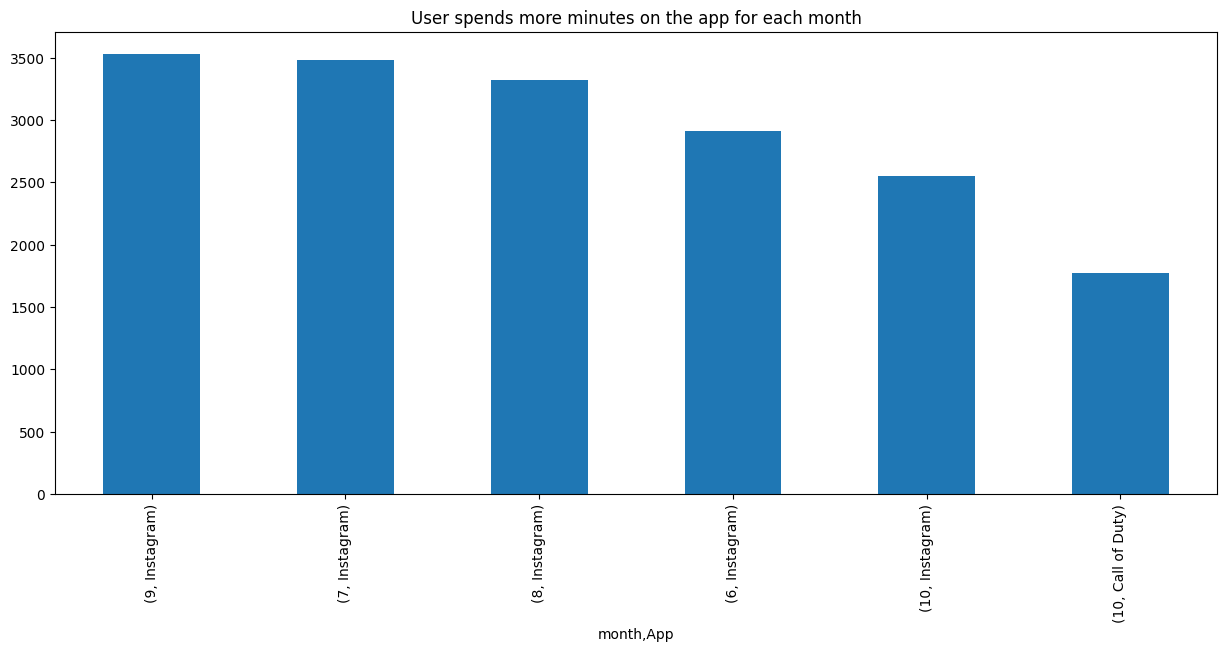

In [93]:
plt.figure(figsize=(15,6))
df.groupby(['month','App']).sum().nlargest(6,'TotalMinutes')['TotalMinutes'].plot(kind='bar')
plt.title('User spends more minutes on the app for each month')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: xlabel='month'>

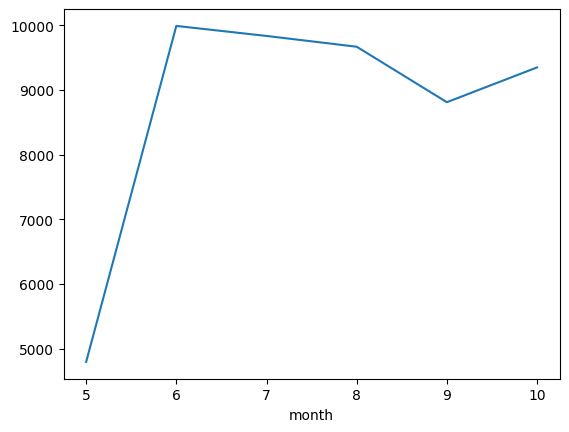

In [94]:
df.groupby(['month']).sum()['TotalMinutes'].plot()

<AxesSubplot: xlabel='Date'>

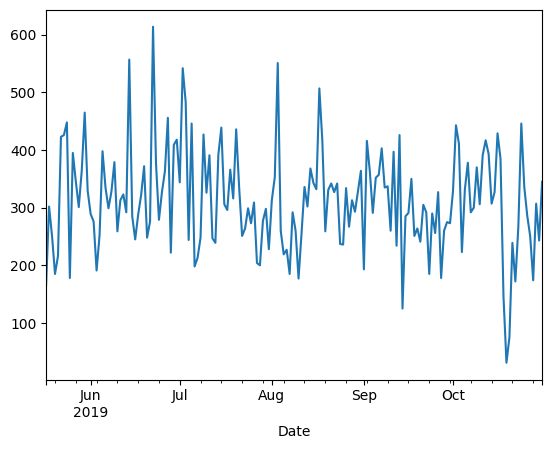

In [95]:
df.groupby(['Date']).sum()['TotalMinutes'].plot()

<AxesSubplot: xlabel='dayofweek'>

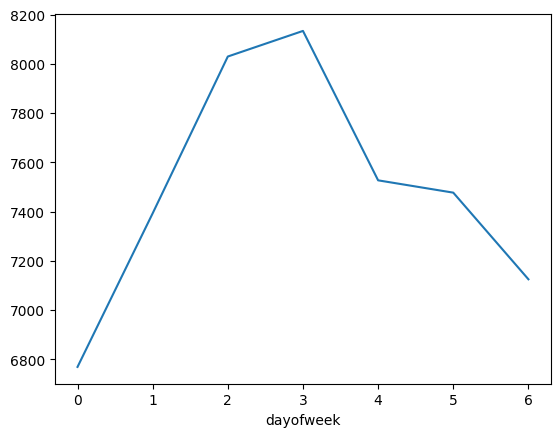

In [96]:
df.groupby(['dayofweek']).sum()['TotalMinutes'].plot()

<AxesSubplot: xlabel='weekofyear'>

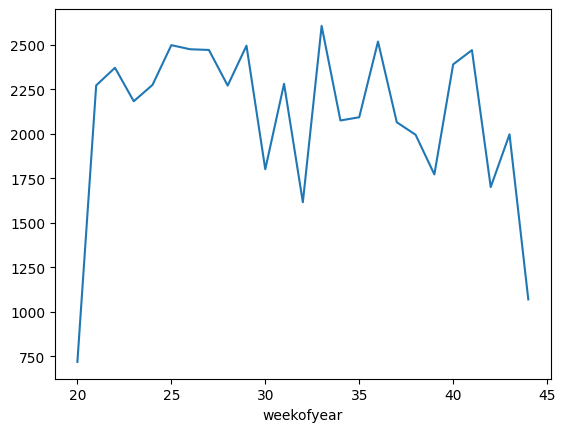

In [97]:
df.groupby(['weekofyear'])['TotalMinutes'].sum().plot()

In [98]:
df.head()

,Date,App,TotalSeconds,TotalMinutes,day,dayofweek,month,quarter,year,dayofyear,weekofyear
0,2019-05-17,App Usage,13,0,17,4,5,2,2019,137,20
1,2019-05-17,Call of Duty,444,7,17,4,5,2,2019,137,20
2,2019-05-17,Camera,53,0,17,4,5,2,2019,137,20
3,2019-05-17,Chrome,39,0,17,4,5,2,2019,137,20
4,2019-05-17,Contacts,24,0,17,4,5,2,2019,137,20


In [99]:
df.drop(["Date",'TotalSeconds','year'],axis=1, inplace=True)

In [100]:
df.head()

,App,TotalMinutes,day,dayofweek,month,quarter,dayofyear,weekofyear
0,App Usage,0,17,4,5,2,137,20
1,Call of Duty,7,17,4,5,2,137,20
2,Camera,0,17,4,5,2,137,20
3,Chrome,0,17,4,5,2,137,20
4,Contacts,0,17,4,5,2,137,20


In [101]:
df=pd.get_dummies(df,drop_first=True)

In [102]:
df.head()

,TotalMinutes,day,dayofweek,month,quarter,dayofyear,weekofyear,App_Adapt sound,App_Airtel,App_Airtel Xstream,...,App_WhatsApp,App_Wi-Fi Direct,App_Wi-Fi calling,App_WordPress,App_Xender,App_Yahoo Mail,App_YouTube,App_Zedge Ringtones & Wallpapers,App_edX,App_redBus
0,0,17,4,5,2,137,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,17,4,5,2,137,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,17,4,5,2,137,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,17,4,5,2,137,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,17,4,5,2,137,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
train_length=int(0.90*df.shape[0])
train=df[0:train_length]
test=df[train_length:].reset_index(drop=True)

In [104]:
y_test=test['TotalMinutes']
X_test=test.drop(['TotalMinutes'],axis=1)
y=train['TotalMinutes']
X=train.drop(['TotalMinutes'],axis=1)

In [105]:
df.tail()

,TotalMinutes,day,dayofweek,month,quarter,dayofyear,weekofyear,App_Adapt sound,App_Airtel,App_Airtel Xstream,...,App_WhatsApp,App_Wi-Fi Direct,App_Wi-Fi calling,App_WordPress,App_Xender,App_Yahoo Mail,App_YouTube,App_Zedge Ringtones & Wallpapers,App_edX,App_redBus
3808,0,31,3,10,4,304,44,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3809,1,31,3,10,4,304,44,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3810,0,31,3,10,4,304,44,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3811,51,31,3,10,4,304,44,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3812,0,31,3,10,4,304,44,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [107]:

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.15, random_state=42)

# MODEL BUILDING

In [108]:

rf=RandomForestRegressor()

In [109]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [110]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [111]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs=1)

In [112]:

rf_random.fit(X_train.values,y_train.values)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   4.4s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.1s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   2.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.1s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   6.8s
[CV] n_estimators=1100, min_samples_split=10, mi

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.7min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [113]:
print("Best Parameters:", rf_random.best_params_)

# Train the best model with optimized parameters
best_rf_model= rf_random.best_estimator_


Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 15}


In [114]:
y_pred = best_rf_model.predict(X_test.values)

In [115]:
print("r2 score is:",r2_score(y_test.values,y_pred))
print("mean squared error  is:",mean_squared_error(y_test.values,y_pred))
print("root mean squared error is:",np.sqrt(mean_squared_error(y_test.values, y_pred)))

r2 score is: 0.5117302396754948
mean squared error  is: 375.8421446899841
root mean squared error is: 19.38664861934584


In [116]:
import pickle 
file=open('app_usage_model.pkl','wb')
pickle.dump(best_rf_model,file)